# 09 - Profit of future with multiple output

## Output format: 3 type of trends 

For each trend, it measures the distance between PoF and the target value

Target value:
- Up trend : >16% of the positive PoF (training data)
- Down trend: >16% of the negative PoF (training data)
- Neutral trend: zero

The distance are measured with 1-tanh scaling: it is 1 when distance is 0, and it fades out quickly when distance increases

```
Up(t) = (1-tanh(max(up_target - PoF(t), 0) * scaling))
Down(t) = (1-tanh(max(PoF(t)- down_target, 0) * scaling))
Neutral(t) = 1-tanh(max(abs(PoF(t) - neutral_target, 0)) * scaling)
```

Target and scaling is applied so that the trend would be around tanh(3) when PoF reach another trend, and keep the present of the trend intensity arround 1/3 of all time (that's why 16% is picked as threshold: 66% - 50%)
```
scaling = 3 / target
```


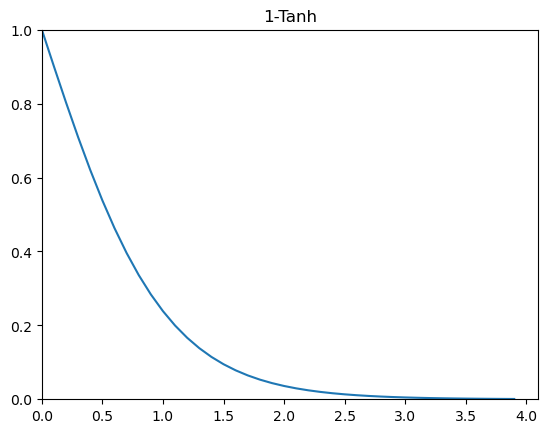

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

x = np.arange(0, 40) / 10
y = 1- np.tanh(x)
plt.plot(x, y)
plt.ylim(0, 1)
plt.xlim(0)
plt.title('1-Tanh')
plt.show()


### Determine the target values of trends

dataSize: 1010
windowSize: 42
testSize: 303
input_scale: 676.967
output_scale: 5.841402995389024
y_pos_mean: 3.4938657860567623
y_neg_mean: 3.7503192019669
scale_target: 3.4938657860567623
y_pos_mean: 2.6817229422782285
y_neg_mean: 2.79059415464533
scale_target: 2.6817229422782285


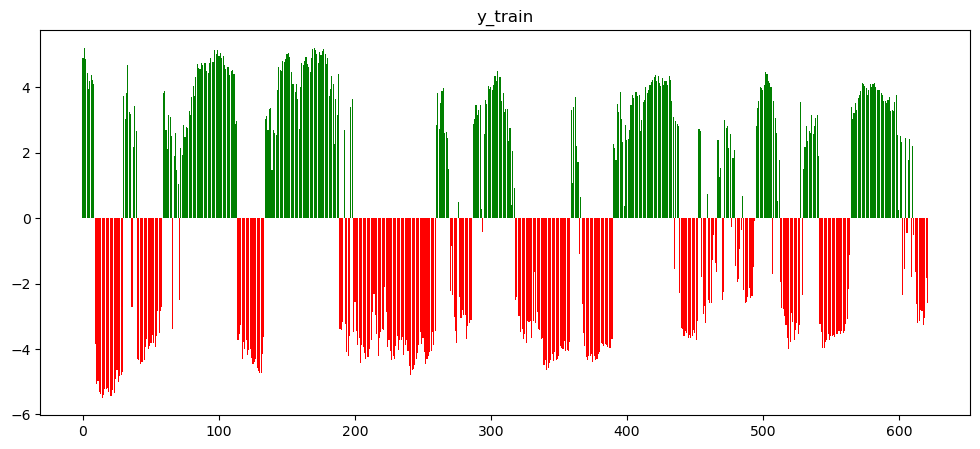

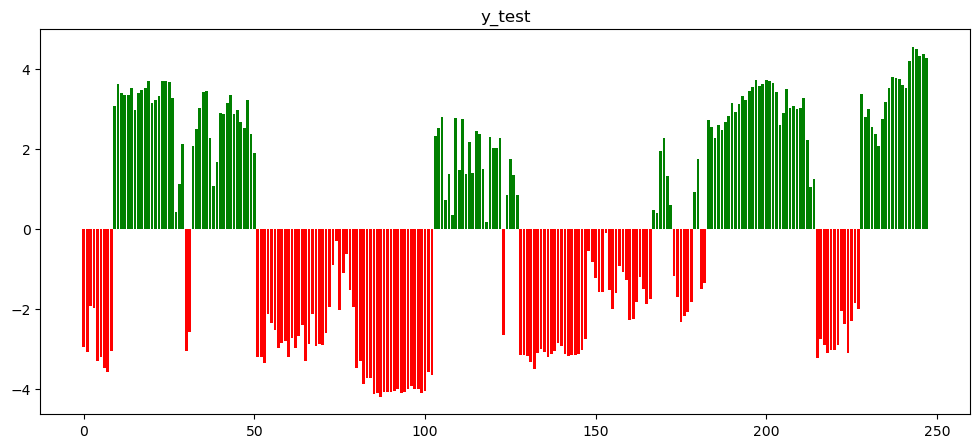

In [2]:
bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']
future_period = 21
profit_of_future_log = covertToLogScale(computeProfitOfFuture(bnb_close_values, future_period))
skip_count = 390

input_data = np.array(bnb_data['Close'][skip_count:-future_period])
output_data = profit_of_future_log[skip_count:]

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(profit_of_future_log)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")

x_train = prepareTrainingInputs(input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(output_data, windowSize, testSize)
x_test = prepareTestingInputs(input_data, windowSize, testSize)
y_test = prepareTestingOutputs(output_data, testSize)

x_train_rs, y_train_rs = undersampleSeriesDataTomekBySign(x_train, y_train)
x_test_rs, y_test_rs = undersampleSeriesDataTomekBySign(x_test, y_test)

y_train_scaled = rescalingBySign(y_train_rs)
y_test_scaled = rescalingBySign(y_test_rs)

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train_scaled)
plt.title('y_train')
plt.show()

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test_scaled)
plt.title('y_test')
plt.show()

posTrendTarget: 2.493205452602697


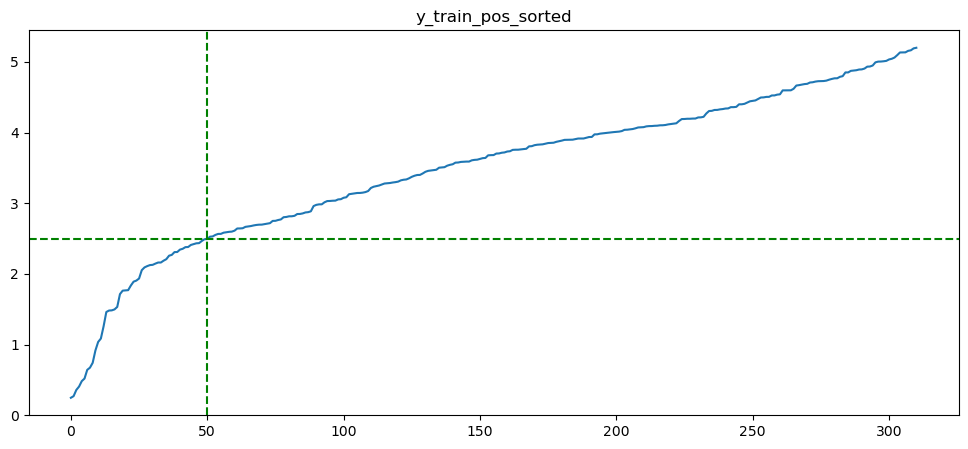

negTrendTarget: 2.5968647373072695


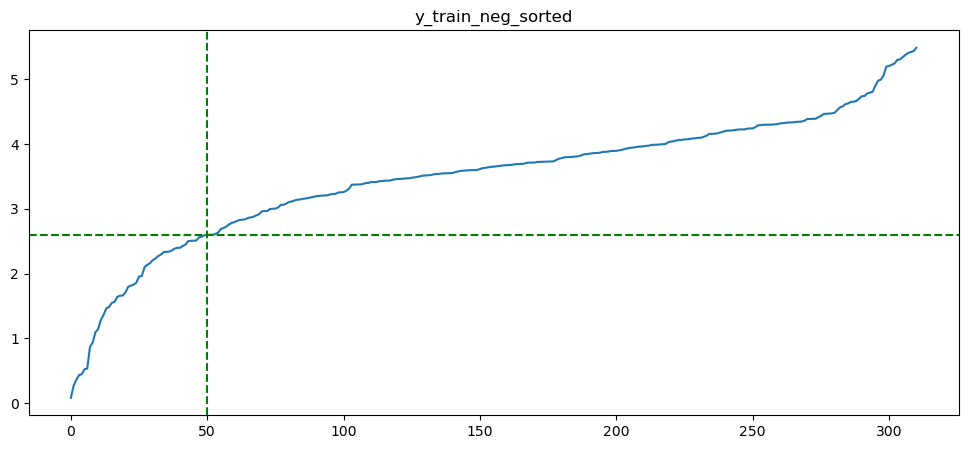

In [ ]:
y_train_pos_sorted = np.sort(y_train_scaled[y_train_scaled>0])
targetIndex = round(len(y_train_pos_sorted)*.16)

posTrendTarget = y_train_pos_sorted[targetIndex]
print(f"posTrendTarget: {posTrendTarget}")
plt.figure(figsize=(12, 5))
plt.plot(y_train_pos_sorted)
plt.axvline(x=targetIndex, color='green', linestyle='--', label='target index')
plt.axhline(y=posTrendTarget, color='green', linestyle='--', label='target value')
plt.title('y_train_pos_sorted')
plt.show()

y_train_neg_sorted = np.sort(np.abs(y_train_scaled[y_train_scaled<0]))
negTrendTarget = y_train_neg_sorted[targetIndex]
print(f"negTrendTarget: {negTrendTarget}")
plt.figure(figsize=(12, 5))
plt.plot(y_train_neg_sorted)
plt.axvline(x=targetIndex, color='green', linestyle='--', label='target index')
plt.axhline(y=negTrendTarget, color='green', linestyle='--', label='target value')
plt.title('y_train_neg_sorted')
plt.show()

In [4]:
np.max([[-1, 4], np.zeros(2)], axis=0)

array([0., 4.])

Lets set both up and down trend target to be 2.5, and the scaling for trend metrics is 3 / 2.5

train up trend mean: 0.4545763889921792
train down trend mean: 0.45769708774509377
train neutral trend mean: 0.43635298005200224
test up trend mean: 0.3869220533609354
test down trend mean: 0.37717535689516607
test neutral trend mean: 0.7495689472456419


Text(0.5, 1.0, 'Trends vs actual PoF (Test)')

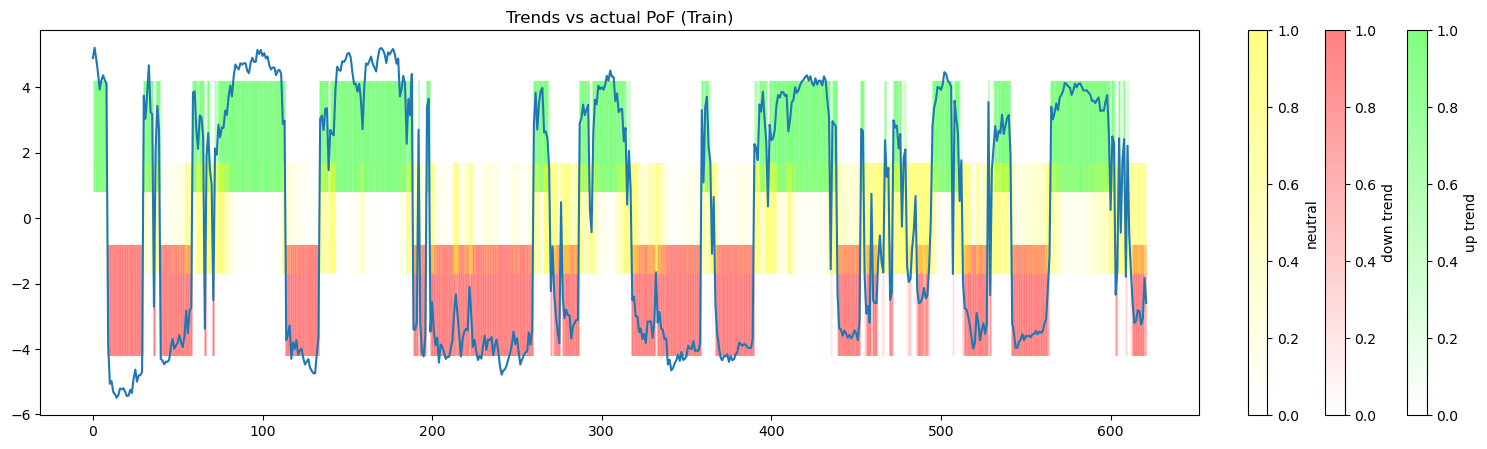

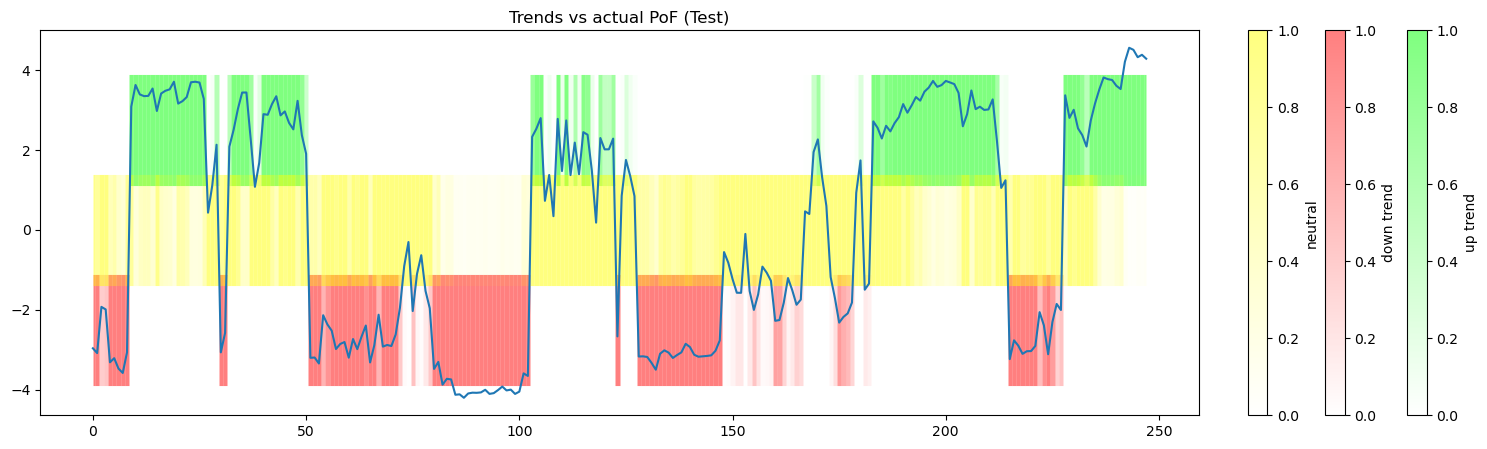

In [227]:
ut_target = 2.5
dt_target = -2.5
nt_target = 2.9 # this is adjusted so that the train neutral trend mean is almost the same as others
scaling = 3 / 2.5

def computeUDNTrend(data, ut_target, dt_target, nt_target, scaling):
  data_count = len(data)
  zeros = np.zeros(data_count)
  up_trend = 1-np.tanh(np.max([ut_target - data, zeros], axis=0) * scaling)
  down_trend = 1-np.tanh(np.max([data - dt_target, zeros], axis=0) * scaling)
  neutral_trend = 1 - np.tanh(np.max([np.abs(data) - nt_target, zeros], axis=0) * scaling)
  return up_trend, down_trend, neutral_trend

from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

def colored_line(x, y, c, **lc_kwargs):
  # Default the capstyle to butt so that the line segments smoothly line up
  default_kwargs = {"capstyle": "butt"}
  default_kwargs.update(lc_kwargs)
  # Compute the midpoints of the line segments. Include the first and last points
  # twice so we don't need any special syntax later to handle them.
  x = np.asarray(x)
  y = np.asarray(y)
  x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
  y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
  # Determine the start, middle, and end coordinate pair of each line segment.
  # Use the reshape to add an extra dimension so each pair of points is in its
  # own list. Then concatenate them to create:
  # [
  #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
  #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
  #   ...
  # ]
  coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
  coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
  coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
  segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)
  lc = LineCollection(segments, **default_kwargs)
  lc.set_array(c)  # set the colors of each segment
  return lc

def drawHorizontalColoredBar(fig, ax, data, yOffset, cmap, linewidth, label, norm=Normalize(vmin=0, vmax=1), drawColorBar=True):
  dataSize = len(data)
  x = [i for i in range(0, dataSize)]
  y = np.zeros(dataSize) + yOffset
  # Create a Normalize object to fix the color scale
  lines = colored_line(x, y, data, linewidth=linewidth, cmap=cmap, norm=norm)
  sm = ax.add_collection(lines)
  if drawColorBar:
    fig.colorbar(sm, label=label, orientation='vertical', fraction=0.02, pad=0.04, shrink=1)

def drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target, norm=Normalize(vmin=0, vmax=1), drawColorBar=True):
  colors = [
      (0, 1, 0, 0),    # Transparent (RGBA)
      (0, 1, 0, 0.5)   # Green with 50% transparency (RGBA)
  ]
  cmap = LinearSegmentedColormap.from_list("transparent_to_green", colors, N=256)
  drawHorizontalColoredBar(fig, ax, up_trend_train, ut_target, cmap, 80, 'up trend', norm=norm, drawColorBar=drawColorBar)
  colors = [
      (1, 0, 0, 0),    # Transparent (RGBA)
      (1, 0, 0, 0.5)   # Red with 50% transparency (RGBA)
  ]
  cmap = LinearSegmentedColormap.from_list("transparent_to_red", colors, N=256)
  drawHorizontalColoredBar(fig, ax, down_trend_train, -ut_target, cmap, 80, 'down trend', norm=norm, drawColorBar=drawColorBar)
  colors = [
      (1, 1, 0, 0),    # Transparent (RGBA)
      (1, 1, 0, 0.5)   # Yellow with 50% transparency (RGBA)
  ]
  cmap = LinearSegmentedColormap.from_list("transparent_to_yellow", colors, N=256)
  drawHorizontalColoredBar(fig, ax, neutral_trend_train, 0, cmap, 80, 'neutral', norm=norm, drawColorBar=drawColorBar)

up_trend_train, down_trend_train, neutral_trend_train = computeUDNTrend(y_train_scaled, ut_target, dt_target, nt_target, scaling)

print(f"train up trend mean: {np.mean(up_trend_train)}")
print(f"train down trend mean: {np.mean(down_trend_train)}")
print(f"train neutral trend mean: {np.mean(neutral_trend_train)}")

up_trend_test, down_trend_test, neutral_trend_test = computeUDNTrend(y_test_scaled, ut_target, dt_target, nt_target, scaling)

print(f"test up trend mean: {np.mean(up_trend_test)}")
print(f"test down trend mean: {np.mean(down_trend_test)}")
print(f"test neutral trend mean: {np.mean(neutral_trend_test)}")

fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Trends vs actual PoF (Train)')

fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Trends vs actual PoF (Test)')


In [228]:
y_train_trend = np.column_stack([up_trend_train, down_trend_train, neutral_trend_train])
y_test_trend = np.column_stack([up_trend_test, down_trend_test, neutral_trend_test])

train_dataset, test_dataset = prepareDataSetFromArray(x_train_rs, y_train_trend, x_test_rs, y_test_trend, shuffle=True, batch_size=256)

Trivial prediction brenchmarking

In [229]:
test_count = len(y_test_trend)
trivial_prediction = np.tile([np.tanh(3), 1, np.tanh(3)], (test_count, 1))
tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, y_test_trend).numpy()

0.66843927

#### [Model1] ARIMA

In [230]:
neuronCount = 128

# Create input to stacks
input = layers.Input(shape=(windowSize,1), name="stack_input")
x = input
x = tf.keras.layers.multiply([x, np.array([1./input_scale])])

# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neuronCount, return_sequences=True)),

x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.LSTM(round(neuronCount/2), activation='relu', return_sequences=True)(x)

residual = tf.keras.layers.LSTM(round(neuronCount/2), return_sequences=True)(input)  # Skip connection
x = tf.keras.layers.Add()([x, residual])  # Adding the residual connection

x = tf.keras.layers.LSTM(round(neuronCount/4), activation='relu')(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation="linear")(x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
# model1.summary()


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch: 6.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 26: early stopping
8/8 [==============================] - 2s 62ms/step - loss: 0.1988 - mse: 0.1988
rmse: 0.44581707593504577


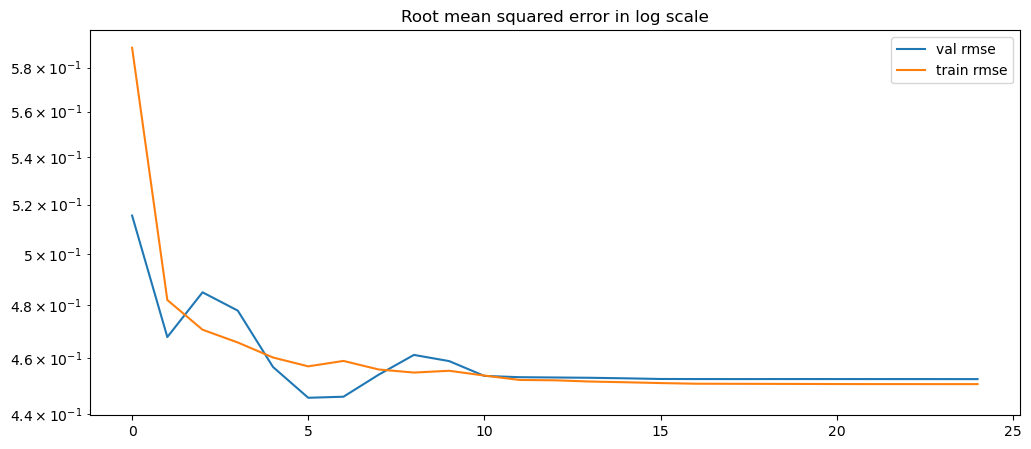

In [231]:
# history1, rmse1, corr1 = standardTrainingAndReport(model1, x_test_rs, y_train_trend, train_dataset, test_dataset, early_stopping_patience=40, early_stopping_restore_best_weights=False, reduce_lr_patience=20)

model = model1

# FIXME: start_from_epoch is not available in this version :(
# train for 4 epochs first
# model.fit(train_dataset,
#           epochs=4,
#           validation_data=test_dataset,
#           verbose=0 # prevent large amounts of training outputs
# )

history = model.fit(train_dataset,
          epochs=5000, # just a large number
          validation_data=test_dataset,
          verbose=0, # prevent large amounts of training outputs
          callbacks=[
            # FIXME: start_from_epoch is not available in this version :(
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)
          ])
plotHistoryRSME(history)
rmse = np.sqrt(model.evaluate(x_test_rs, y_test_trend)[0])
print(f"rmse: {rmse}")

In [213]:
# model1.save('models/model9-1')

In [232]:
prediction = model.predict(x_train_rs)
corr = [np.corrcoef(prediction[:,i].reshape(-1), y_train_trend[:,i].reshape(-1))[0, 1] for i in range(len(y_train_trend[0]))]
print(f"corr: {corr}")

history1, rmse1, corr1 = history, rmse, corr

corr: [0.23305234549161305, 0.3878348108534459, 0.18302452520971413]


Text(0.5, 1.0, 'Prediction vs actual (neutral)')

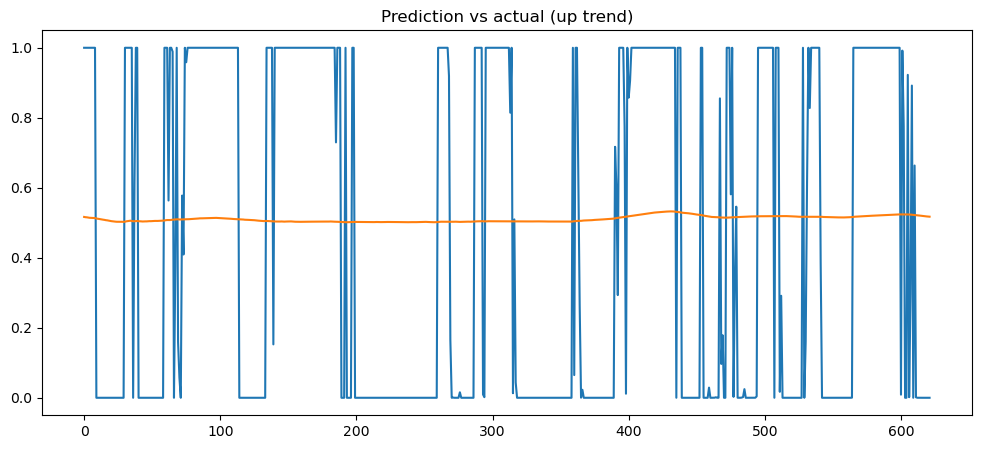

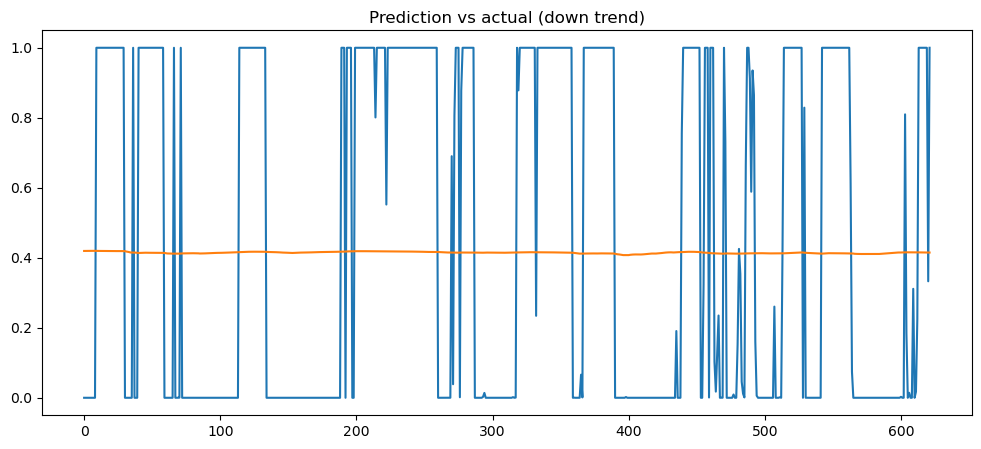

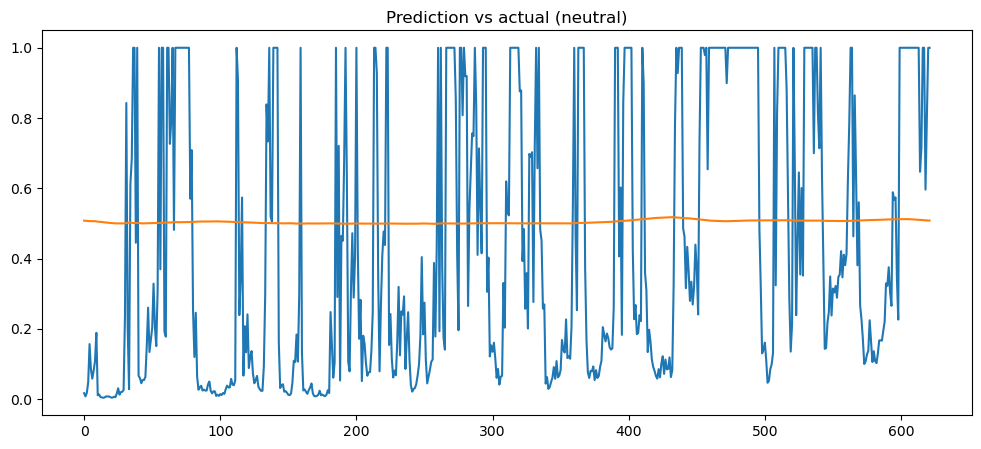

In [233]:
plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,0])
plt.plot(prediction[:,0])
plt.title('Prediction vs actual (up trend)')

plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,1])
plt.plot(prediction[:,1])
plt.title('Prediction vs actual (down trend)')

plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,2])
plt.plot(prediction[:,2])
plt.title('Prediction vs actual (neutral)')

Text(0.5, 1.0, 'Training prediction (no norm)')

<Figure size 640x480 with 0 Axes>

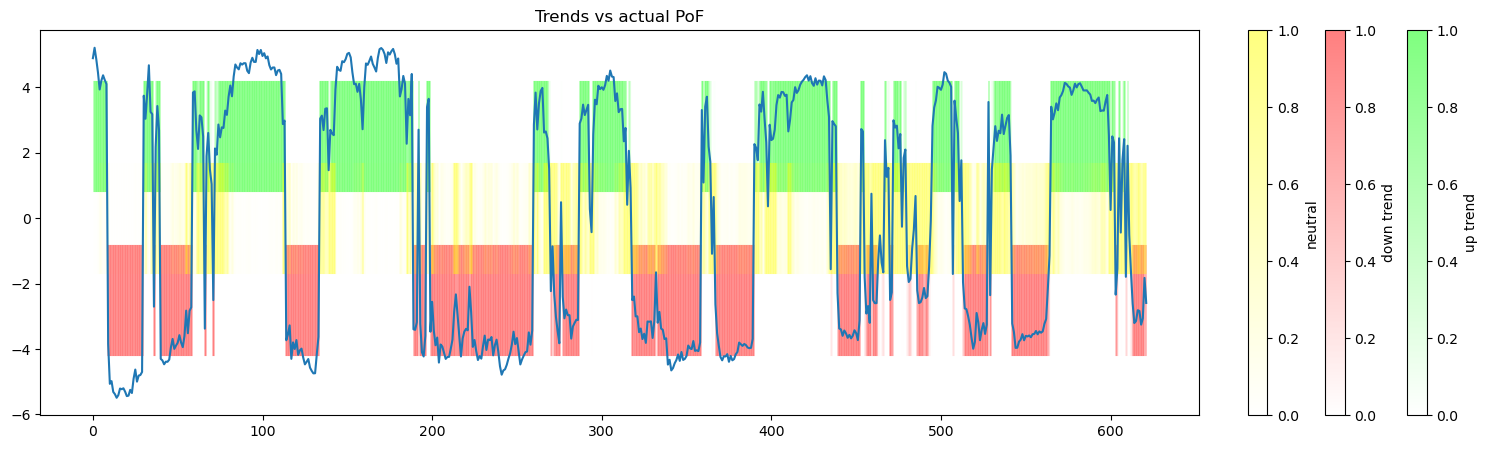

<Figure size 640x480 with 0 Axes>

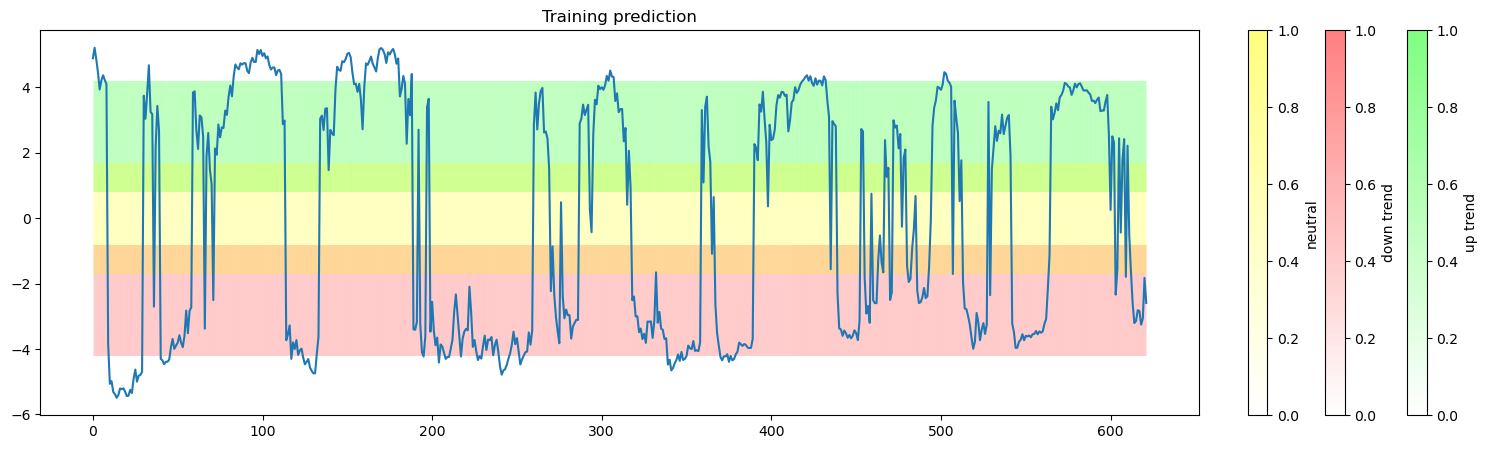

<Figure size 640x480 with 0 Axes>

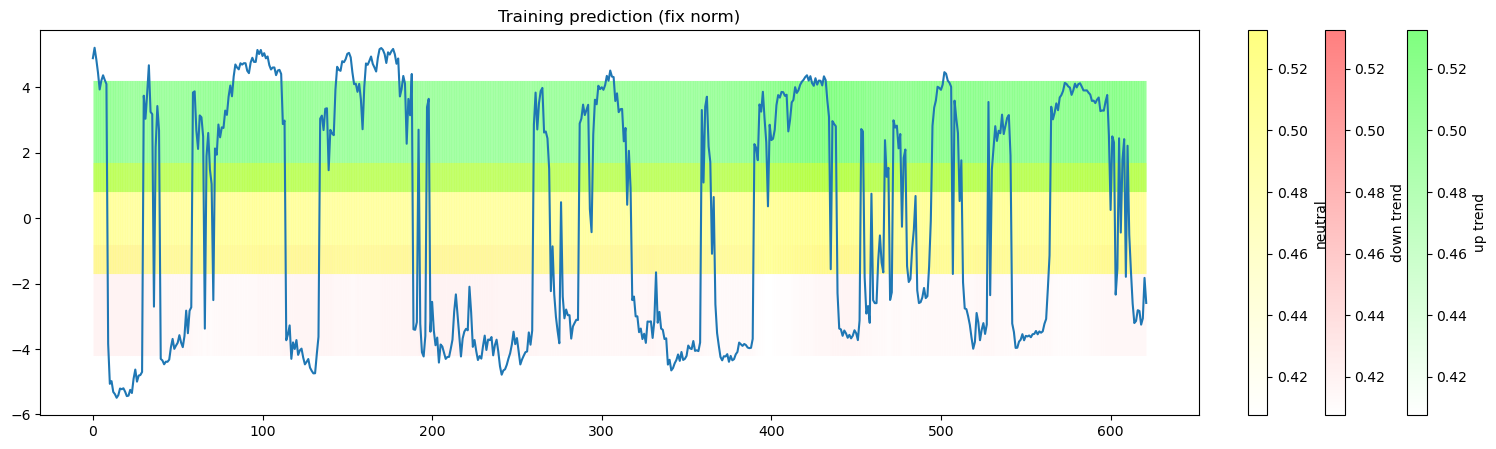

<Figure size 640x480 with 0 Axes>

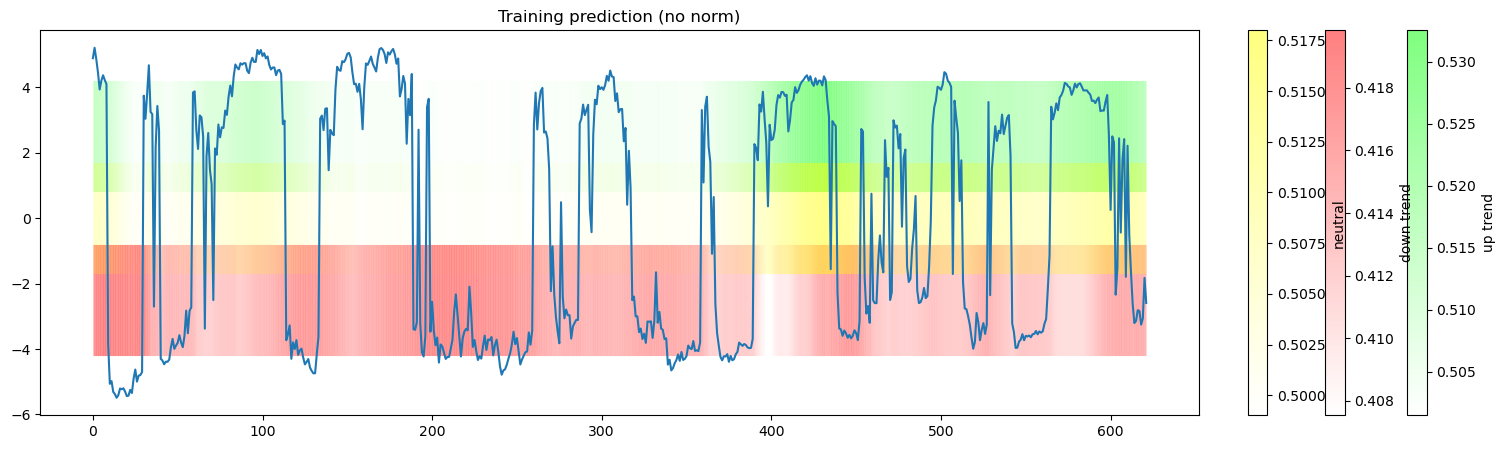

In [234]:
# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction (no norm)')


Text(0.5, 1.0, 'Testing prediction (no norm)')

<Figure size 640x480 with 0 Axes>

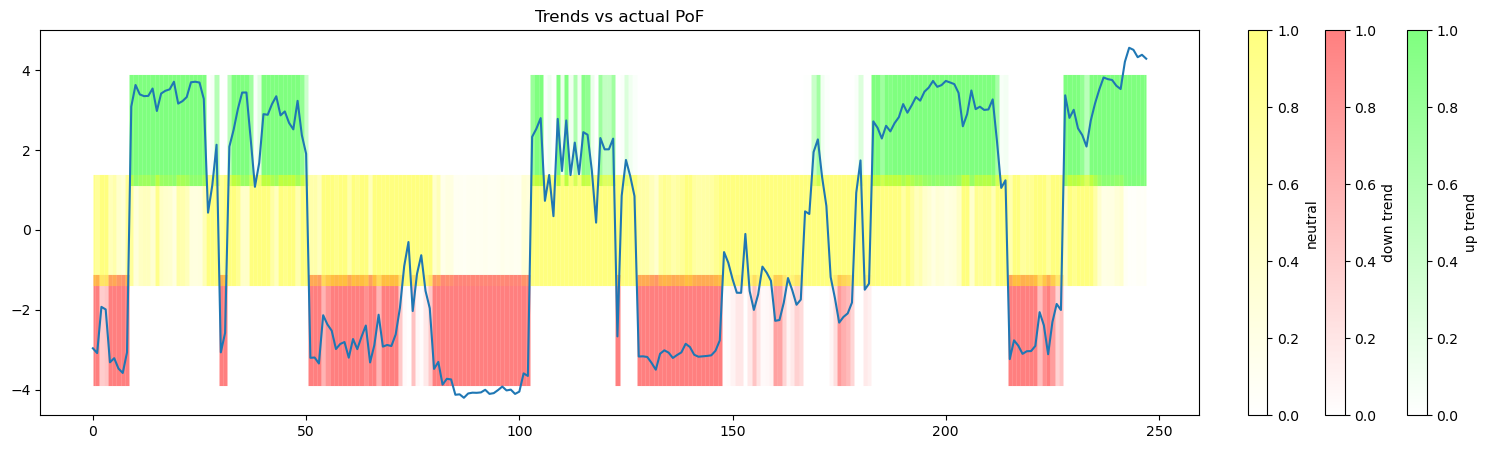

<Figure size 640x480 with 0 Axes>

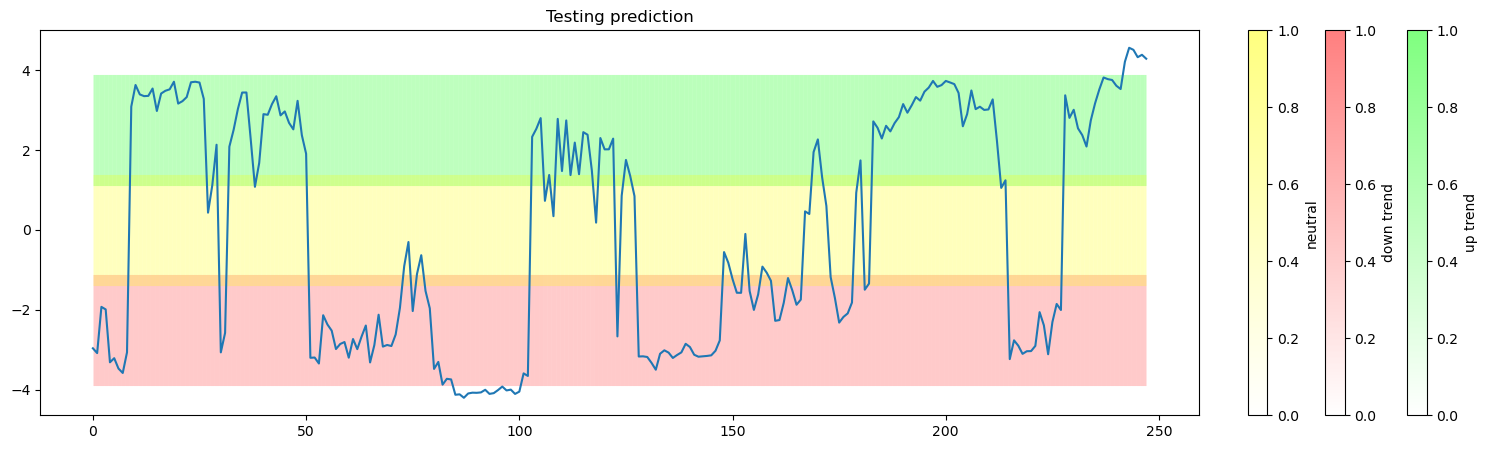

<Figure size 640x480 with 0 Axes>

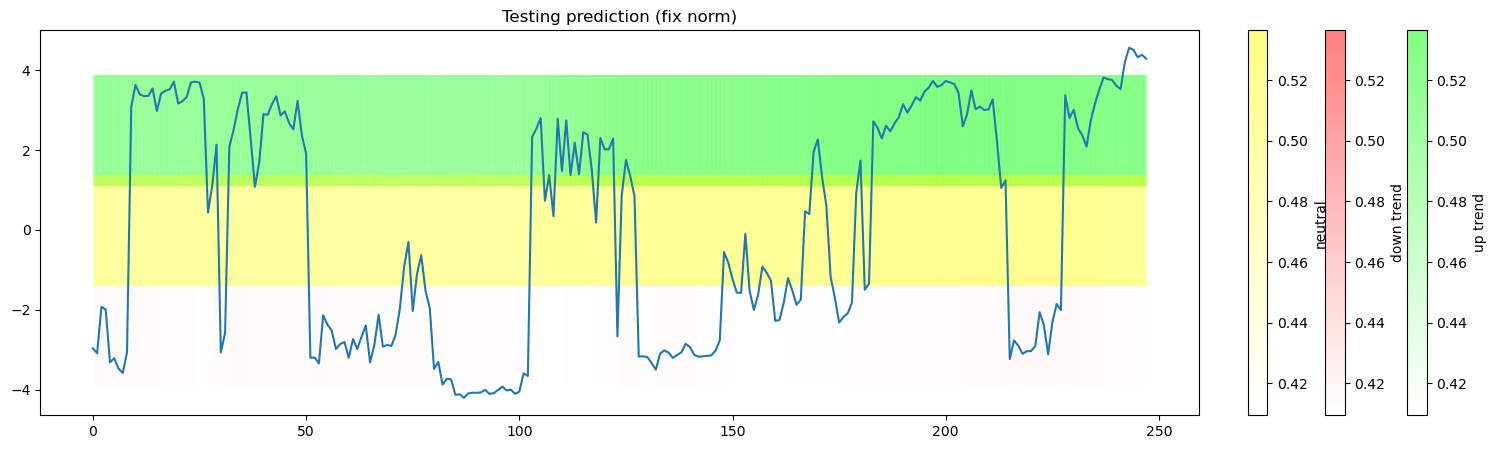

<Figure size 640x480 with 0 Axes>

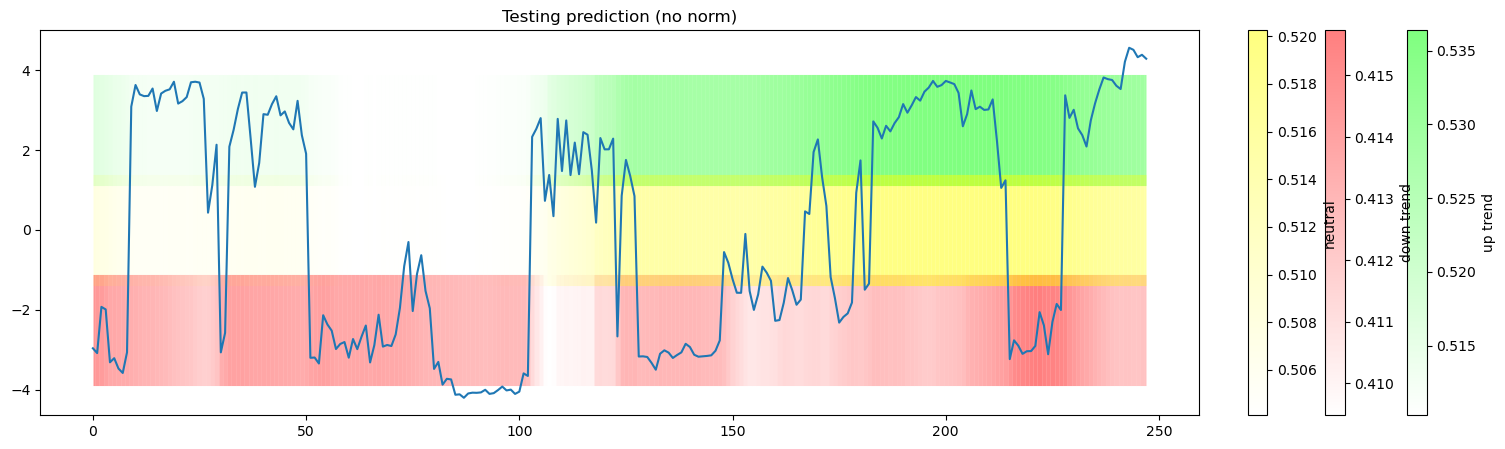

In [235]:
prediction = model.predict(x_test_rs)

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction (no norm)')

#### [Model2] N-BEATS

In [ ]:
train_dataset, test_dataset = prepareDataSetFromArray(x_train_rs, y_train_trend, x_test_rs, y_test_trend, shuffle=True)

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = tf.keras.layers.multiply([x, np.array([1./input_scale])])
x = buildNBeatLayers(windowSize, windowSize+3, 3, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model2 = tf.keras.Model(inputs=input, outputs=x)
model2.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.0005),
              metrics=["mse"])


Epoch 18: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 28: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Restoring model weights from the end of the best epoch: 13.

Epoch 33: ReduceLROnPlateau reducing learning rate to 5.000000555810402e-08.
Epoch 33: early stopping
8/8 [==============================] - 3s 30ms/step - loss: 0.1824 - mse: 0.1824
rmse: 0.4271012763774434


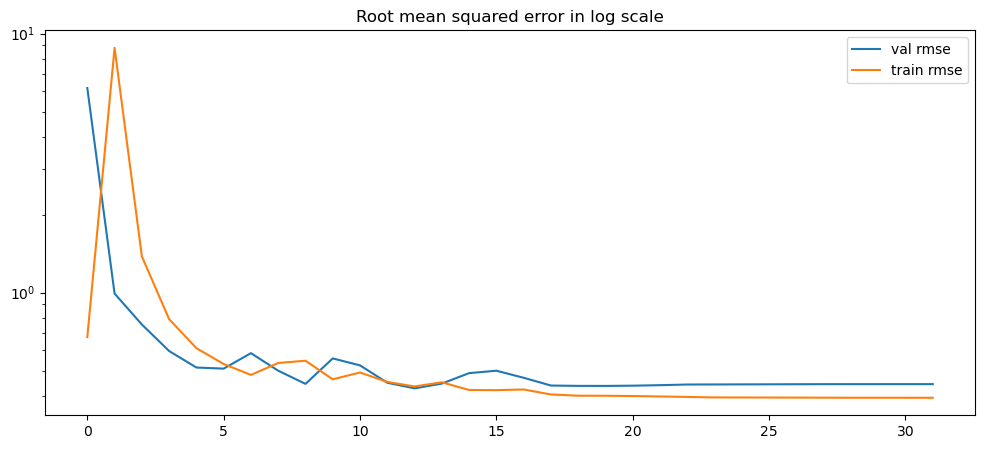

In [219]:
# history2, rmse2, corr2 = standardTrainingAndReport(model2, x_test_rs, y_test_scaled, train_dataset, test_dataset)

# train for 8 epochs first
model.fit(train_dataset,
          epochs=8,
          validation_data=test_dataset,
          verbose=0 # prevent large amounts of training outputs
)

model = model2
history = model.fit(train_dataset,
          epochs=5000, # just a large number
          validation_data=test_dataset,
          verbose=0, # prevent large amounts of training outputs
          callbacks=[
            # FIXME: start_from_epoch is not available in this version :(
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1)
          ])
plotHistoryRSME(history)
rmse = np.sqrt(model.evaluate(x_test_rs, y_test_trend)[0])
print(f"rmse: {rmse}")

In [220]:
# model2.save('models/model9-2') 

In [237]:
prediction = model.predict(x_train_rs)
corr = [np.corrcoef(prediction[:,i].reshape(-1), y_train_trend[:,i].reshape(-1))[0, 1] for i in range(len(y_train_trend[0]))]
print(f"corr: {corr}")

history2, rmse2, corr2 = history, rmse, corr

corr: [0.23305234549161305, 0.3878348108534459, 0.18302452520971413]


Text(0.5, 1.0, 'Prediction vs actual (neutral)')

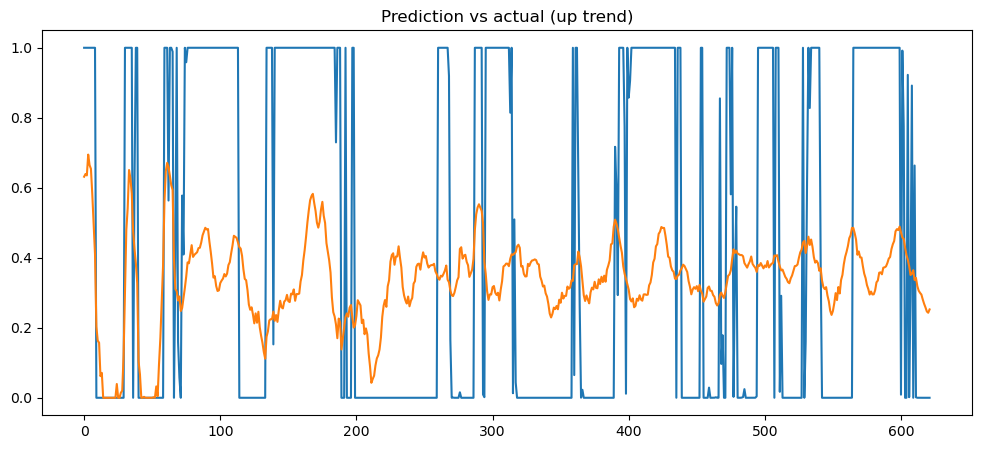

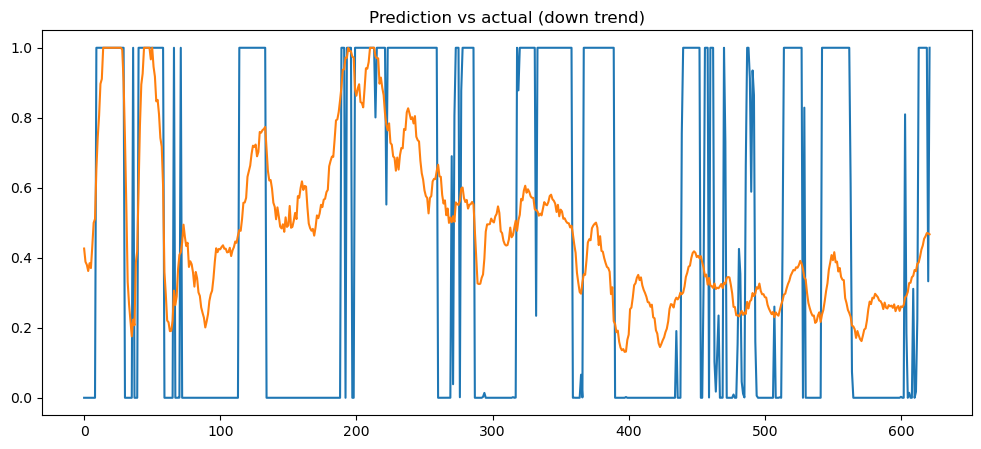

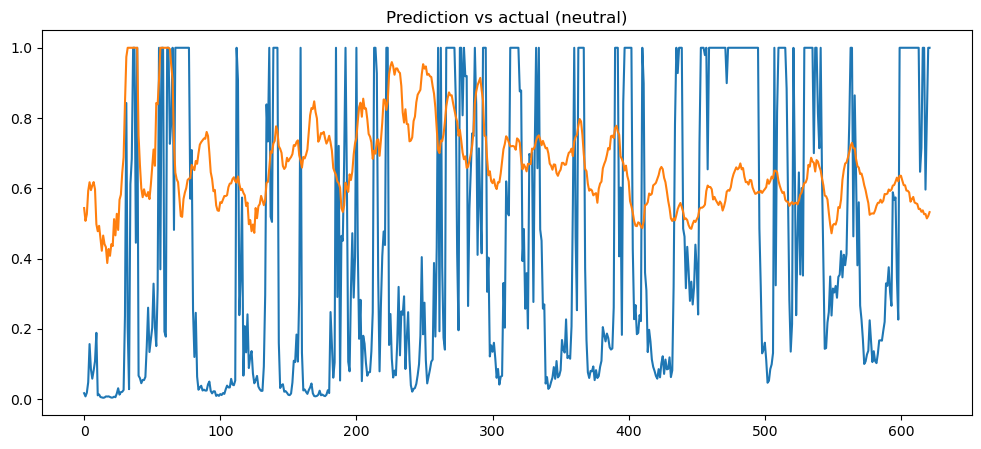

In [222]:
# clip values to [0, 1] before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,0])
plt.plot(prediction[:,0])
plt.title('Prediction vs actual (up trend)')

plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,1])
plt.plot(prediction[:,1])
plt.title('Prediction vs actual (down trend)')

plt.figure(figsize=(12, 5))
plt.plot(y_train_trend[:,2])
plt.plot(prediction[:,2])
plt.title('Prediction vs actual (neutral)')

Text(0.5, 1.0, 'Training prediction (no norm)')

<Figure size 640x480 with 0 Axes>

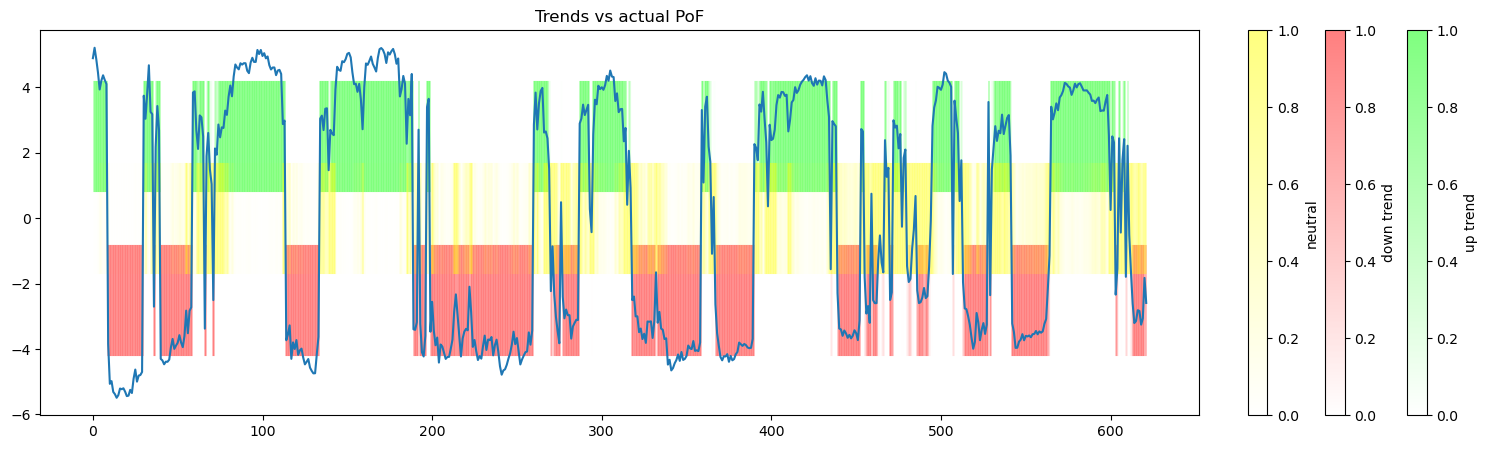

<Figure size 640x480 with 0 Axes>

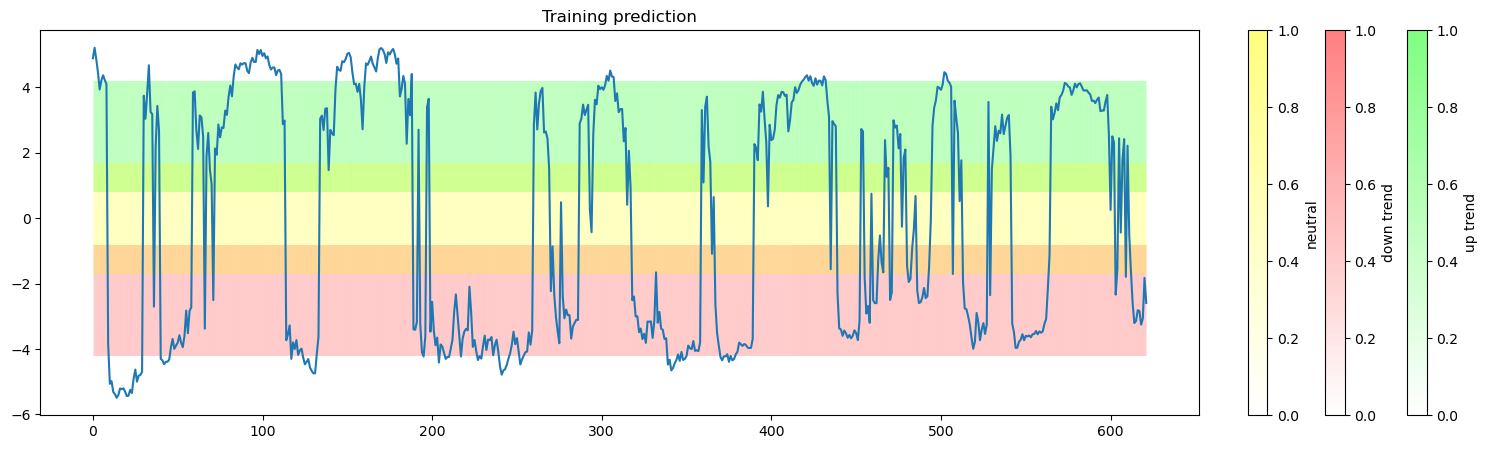

<Figure size 640x480 with 0 Axes>

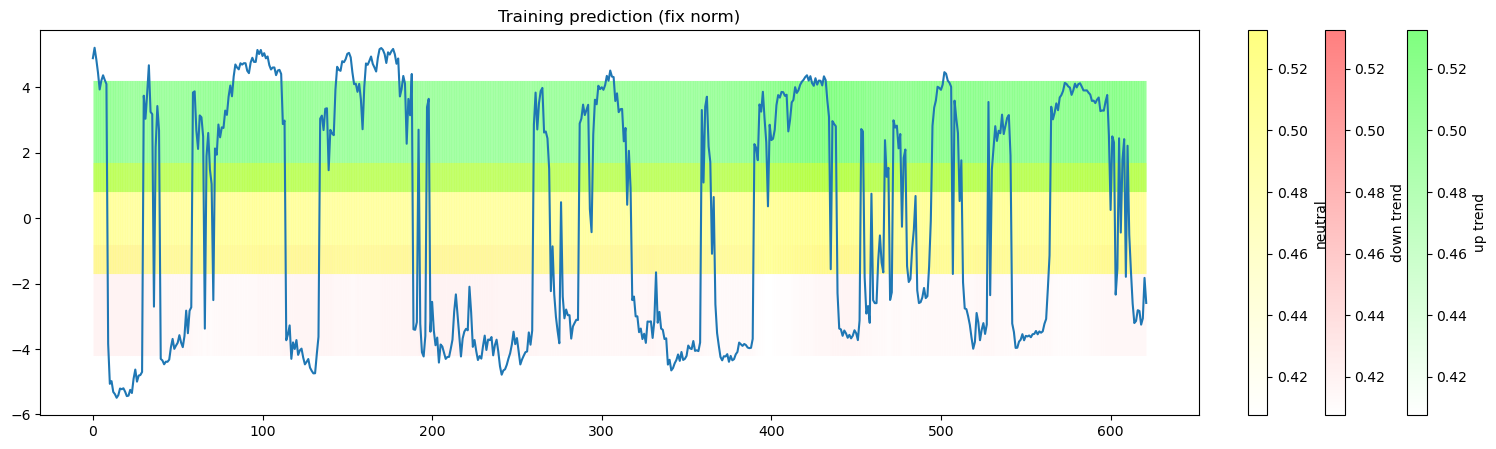

<Figure size 640x480 with 0 Axes>

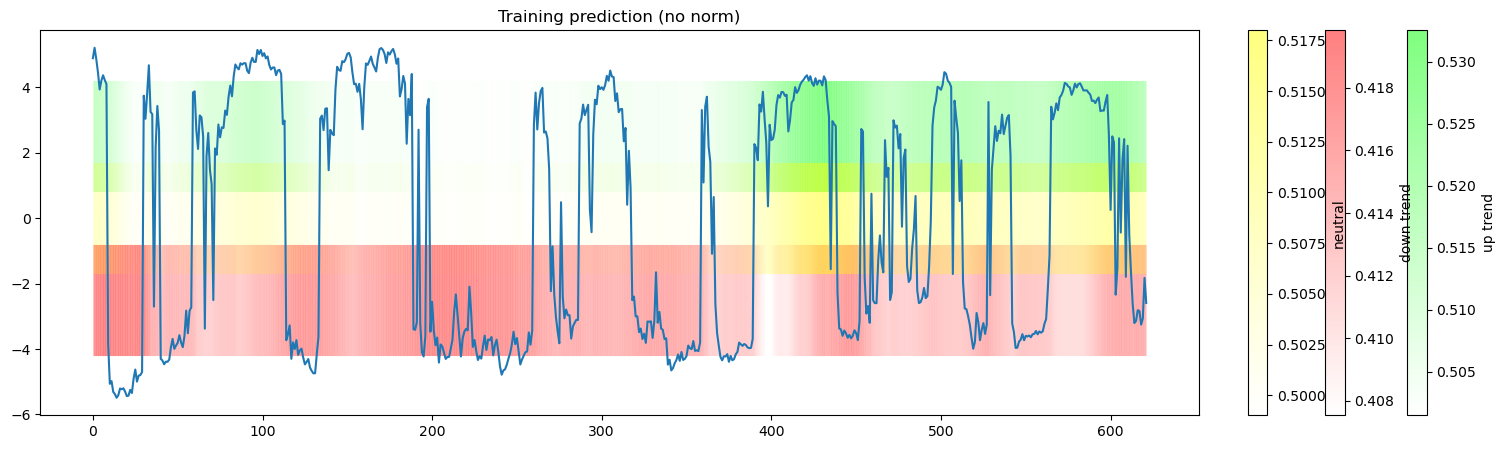

In [238]:
plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train_scaled, label='actual')
ax.set_title('Training prediction (no norm)')

Text(0.5, 1.0, 'Testing prediction (no norm)')

<Figure size 640x480 with 0 Axes>

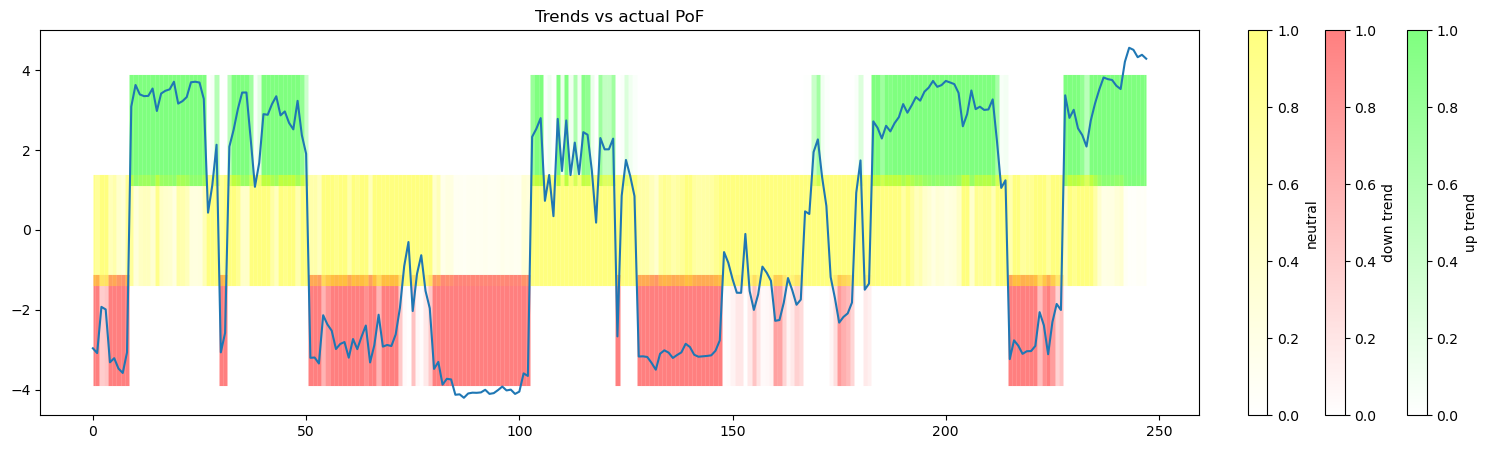

<Figure size 640x480 with 0 Axes>

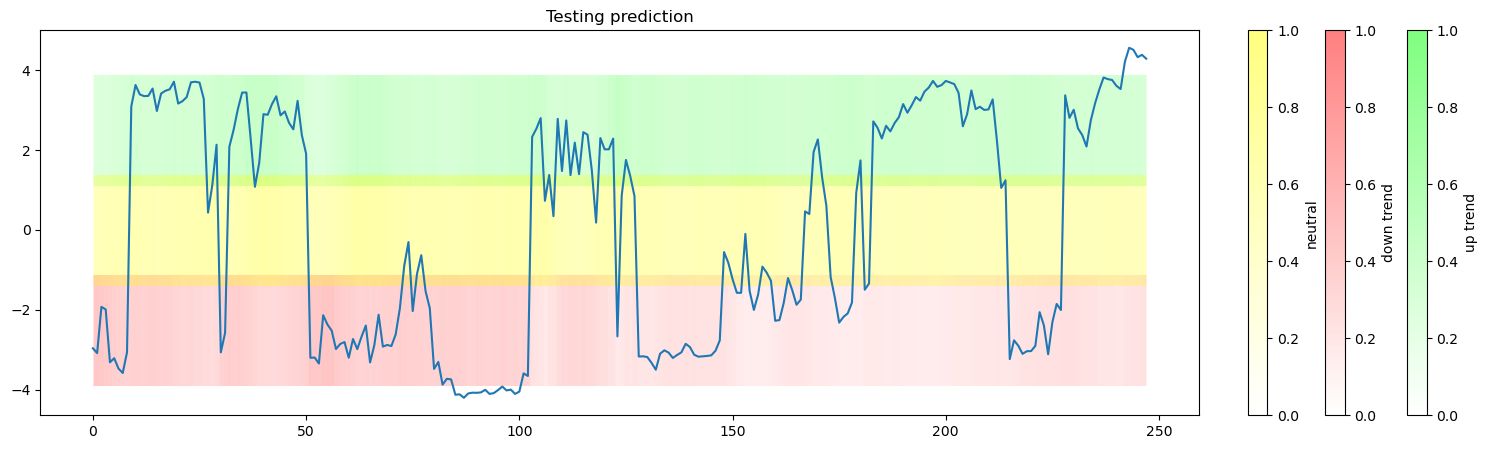

<Figure size 640x480 with 0 Axes>

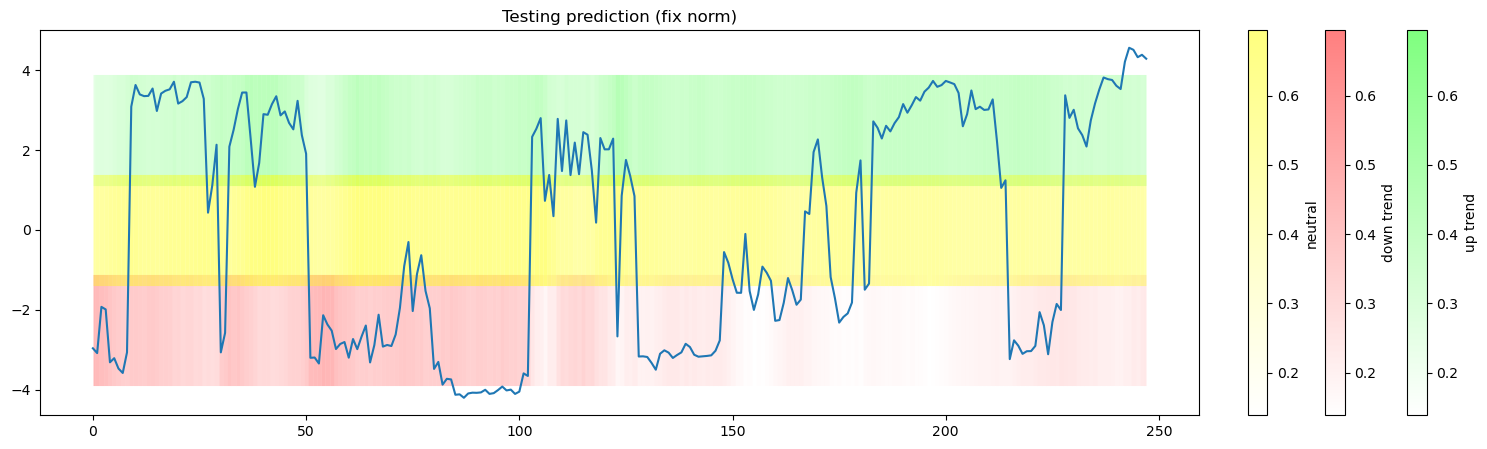

<Figure size 640x480 with 0 Axes>

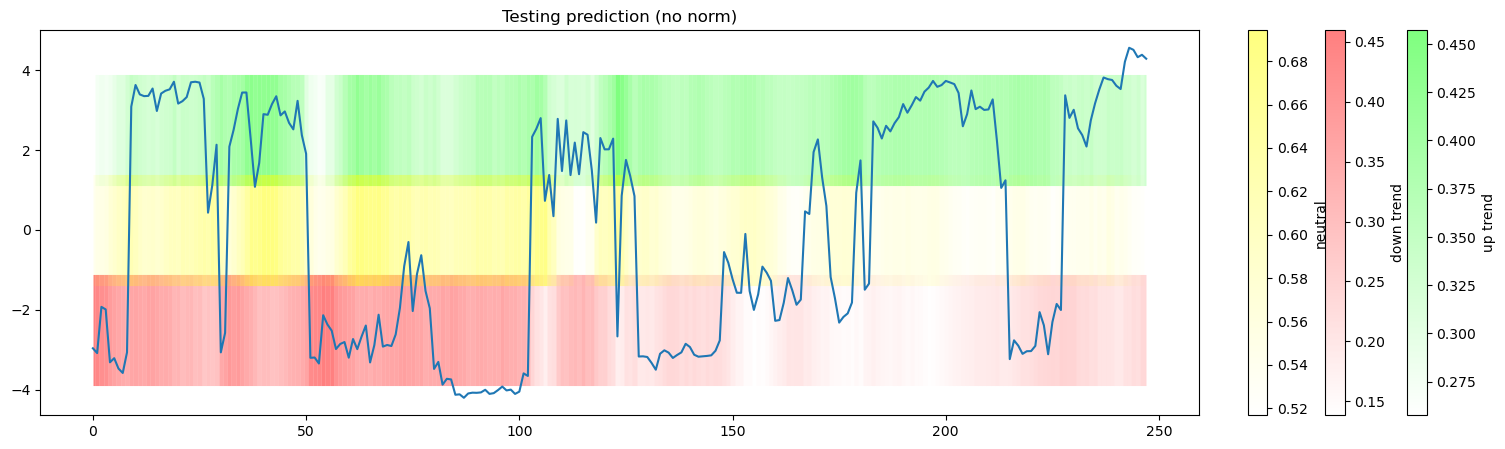

In [224]:
prediction = model.predict(x_test_rs)

# clip values to [0, 1] before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test_scaled, label='actual')
ax.set_title('Testing prediction (no norm)')

Seems that is not a good idea to train with all three targets. Usually one of them is dominating the trainning.